# Проверка гипотез по увеличению выручки для крупного интернет-магазина.

**Цель исследования**

1. Осуществить приоритезацию разработанных гипотез
2. Провести анализ результатов A/B-теста

**Описание данных**

Предоставлены файлы с данными:  
`hypothesis.csv` хранит данные о гипотезах  
`orders.csv` — информацию о заказах  
`costs_info_short.csv` — информацию о расходах на рекламу.


Структура `hypothesis.csv`:
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура `orders.csv`: 
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Структура `visitors.csv`:
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

**Ход исследования**

О качестве данных ничего не известно. Поэтому предварительно необходимо произвести обзор данных и при необходимости осуществить предобработку данных.

Таким образом, работа по проекту пройдет по этапам:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ. 
     - Приоретизация гипотез. 
     - Проверка гипотез.
 4. Выводы.


### Обзор данных

In [1]:
# импорт библиотек pandas, numpy, seaborn, matplotlib и stats
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats

from pandas.plotting import register_matplotlib_converters

# отключаем предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# отображение графиков в jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# Зададим параметры отображения графиков
plt.rc('axes', titlesize = 15, grid = True)
plt.rc('grid', alpha = 0.2)
plt.rc('figure', figsize = (11, 5))
plt.rc('lines', linewidth=3)

# максимальное отображение колонок и значений
pd.set_option('display.max_colwidth', None) 

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

In [2]:
# чтение таблиц с данными и сохранение в visits, orders, costs
try:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'), # журнал посещений
        pd.read_csv('orders.csv'), # данные о покупках
        pd.read_csv('visitors.csv') # расходы на рекламу
    )
except:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )

In [3]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице `hypothesis` 5 колонок и 9 строк.  
Тип данных  - `int64`, `object`.  
Пропуски отсутсвуют.  
Для удбства работы приведем названия всех колонок к нижнему регистру.

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В таблице `orders` 5 колонок и 1197 строк.  
Тип данных  - `int64`, `object`.  
Пропуски отсутсвуют.  
В колонке `date` требуется заменить тип данных на `datetime`

In [7]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице `visitors` 3 колонки и 62 строки.  
Тип данных  - `int64`, `object`.  
Пропуски отсутсвуют.  
В колонке `date` требуется заменить тип данных на `datetime`

### Предобработка данных

#### Приведение названий колонок к единому стилю

In [9]:
# приведение названий столбцов data к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

#### Обработка пропусков

In [10]:
# проверим отсутсвие пропусков
list_tables = [hypothesis, orders, visitors]
for i in list_tables:
    print('══════════════')
    print(i.isna().sum().sort_values())

══════════════
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
══════════════
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
══════════════
date        0
group       0
visitors    0
dtype: int64


#### Изменение типов данных

In [11]:
# обработка колонки date в таблице orders
orders['date'] = pd.to_datetime(orders['date'])
# обработка колонки date в таблице visitors
visitors['date'] = pd.to_datetime(visitors['date'])

#### Выявление дубликатов

In [12]:
# проверим наличи дубликатов
list_tables = [hypothesis, orders, visitors]
for i in list_tables:
    print(i.duplicated().sum())

0
0
0


In [13]:
# определим даты начала и окончания эксперимента по данным таблицы о заказах
orders.date.apply(['count', 'min', 'max'])   

count                   1197
min      2019-08-01 00:00:00
max      2019-08-31 00:00:00
Name: date, dtype: object

In [14]:
# определим даты начала и окончания эксперимента по данным расходов на рекламу
visitors.date.apply(['count', 'min', 'max'])   

count                     62
min      2019-08-01 00:00:00
max      2019-08-31 00:00:00
Name: date, dtype: object

In [15]:
#определим количество групп и количество записей по ним в заказах
orders.group.value_counts()

B    640
A    557
Name: group, dtype: int64

In [16]:
#определим количество групп и количество записей по ним в расходах на рекламму
visitors.group.value_counts()

B    31
A    31
Name: group, dtype: int64

In [17]:
print('уникальные пользователия А:', orders.query('group=="A"')['visitorId'].nunique())
print('уникальные пользователия B:', orders.query('group=="B"')['visitorId'].nunique())

уникальные пользователия А: 503
уникальные пользователия B: 586


**Вывод**
1. Групп в эксперименте две - А и В;
2. Начало и окончание эксперимента: с 2019-08-01 по 2019-08-31;
3. Количество уникальных пользователей, которые сделали заказ(покупатели) в группе А - 503, в группе В - 586
4. Анализ покупателей показал, что они попали в обе группы.

### Исследовательский анализ

#### Приоритизация гипотез

In [18]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В таблице hypothesis 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

`Reach` — скольких пользователей затронет изменение, которое хотитим внести;  
`Impact` — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;  
`Confidence` — насколько мы уверены, что это изменение повлияет на пользователей именно так;  
`Efforts` — сколько стоит протестировать эту гипотезу. 

Шкала оценки от 0 до 10.

Для приоритизации гипотез будем использовать фреймворки ICE and RICE

In [19]:
# определим приоритет для гипотез методом ICE и пронумеруем гипотезы по убыванию приоритета
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'],2)
hypothesis = hypothesis.sort_values(by='ICE', ascending = False)
hypothesis.index = np.arange(1,len(hypothesis)+1)
hypothesis[['hypothesis','ICE']]

,hypothesis,ICE
1,"Запустить акцию, дающую скидку на товар в день рождения",16.20
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
3,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
4,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
5,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
7,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
8,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
9,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [20]:
# для сравнения отпрелим приоритет гипотез фреймворком RICE и пронумеруем гипотезы по убыванию приоритета
hypothesis['RICE'] = hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach'] / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by = ['RICE', 'ICE'], ascending = False)
hypothesis.index = np.arange(1,len(hypothesis)+1)
hypothesis[['hypothesis','ICE','RICE']]

,hypothesis,ICE,RICE
1,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
3,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
4,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
5,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
6,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
7,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
8,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
9,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


При применении приоритезации гипотез метода ICE, тройка лидеров:  
1. Запустить акцию, дающую скидку на товар в день рождения;
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

Однако, если применять метод приоритезации RICE, тройка лидеров выглядит иначе:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет-магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Из полученных данных мы видим серьёзные различия в выборе приората среди гипотез.
Метод приоритезации ICE не учитывает количество пользователей, которых затронет изменение, а RICE учитывает — это единственное, что различат эти два метода. Признак Reach очень важный, поэтому метод RICE, более приориттный.

#### Анализ A/B-теста

Перед началом анализа результатов, проверим что каждый пользователь, попавший в одну из групп теста, остался в ней до конца теста. Если пользователь видит разные вариации теста, неизвестна какая из них повлияла на него. Поэтому для этих пользователей нельзя интерпретировать результаты однозначно

In [21]:
#определяем дубликаты и сохраням список visitorId в переменную dublicates
dublicates = (orders
            .groupby('visitorId')['group']
            .agg('nunique')
            [orders.groupby('visitorId')['group'].agg('nunique')>1]
            .index.tolist()
           )
print('Количество пользователей, которые попали в обе группы:', len(dublicates))

Количество пользователей, которые попали в обе группы: 58


In [22]:
#опрделим долю в потери данных, если удалить записи с дубликтами
len(orders.query('visitorId in @dublicates'))/len(orders)

0.15121136173767752

In [23]:
#опрделим долю пользователей, котрые попали в обе группы
len(dublicates)/orders.visitorId.nunique()

0.05625606207565471

К сожалению, у нас были обнаружены пользователи, которые попали в обе группы эксперимента.  
Поэтому есть риск однозначно интерпретировать данные исследования.  
Однако, так как у нас тестовое задание, есть ограничение по выявлению обстоятельств случившегося, удалять дубликаты я не буду. Нет возможности определить связь таблиц заказов и визитов.

In [24]:
#Проверим отличие количества пользователей, попавших в разные группы в процентах. Отличие не должно быть боле чем на 0.5%
group_a = visitors.query('group == "A"')['visitors'].sum()
group_b = visitors.query('group == "B"')['visitors'].sum()

(1 - group_a/group_b)*100

0.9515753859166809

In [25]:
visitors.groupby('group')['visitors'].sum().pct_change()

group
A         NaN
B    0.009607
Name: visitors, dtype: float64

Отличие между группами в пользователях <0.5%. Далее переходим к анализу имеющихся у нас результатов A/B

In [26]:
# конвертеры, которые позволяют использовать типы pandas в matplotlib 
register_matplotlib_converters()

# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

##### Кумулятивная выручка по группам

In [27]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


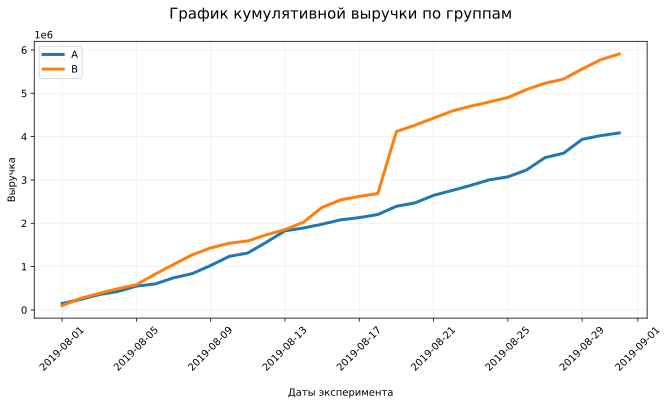

In [28]:
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам'+"\n")
plt.xlabel("\n"+"Даты эксперимента")
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста для А, есть незначительный скачок.
Для B выручка тоже растет, однако наблюдается резкий скачок, который может сигнализировать о всплесках числа заказов(рост конверсии, срднего чека), либо о появлении очень дорогих заказов в выборке.

##### Кумулятивный средний чек по группам

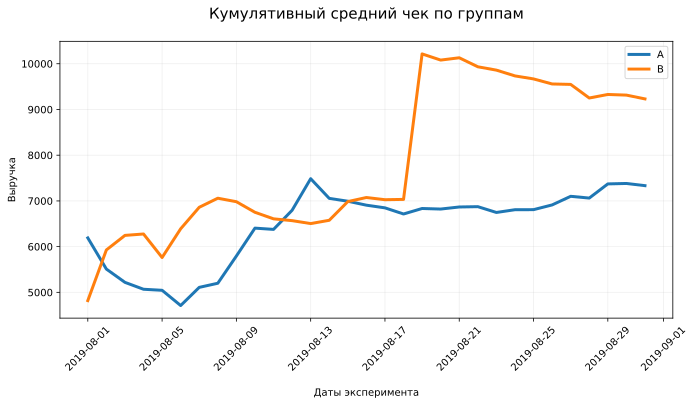

In [29]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам'+"\n")
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.xlabel("\n"+"Даты эксперимента")
plt.legend();

Средний чек для группы А становится равномерным ближе к концу теста. Для В мы видим тотже скачок и плавно снижение.
Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике).

##### Относительное изменение кумулятивного среднего чека группы B к группе A

In [30]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = (cumulativeRevenueA
                           .merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
                          )

In [31]:
# определим средне для каждой группы
mergedCumulativeRevenue['A_mean'] = ((mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])
                                     .round(0)
                                     .astype(int))
mergedCumulativeRevenue['B_mean'] = ((mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
                                     .round(0)
                                     .astype(int))

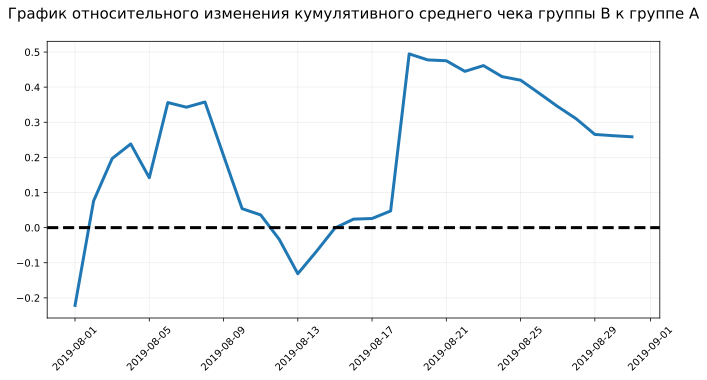

In [32]:
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],  \
  (mergedCumulativeRevenue['B_mean']/mergedCumulativeRevenue['A_mean'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A'+"\n")
plt.xticks(rotation=45);

В нескольких точках график различия между сегментами резко «скачет». Выбросы очевидны

##### Кумулятивное среднее количество заказов на посетителя по группам

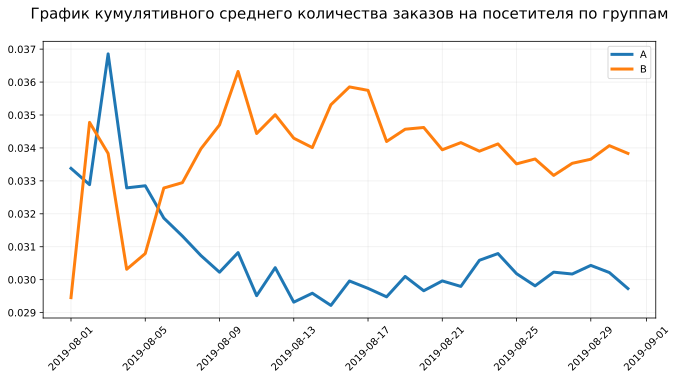

In [33]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')


plt.title('График кумулятивного среднего количества заказов на посетителя по группам'+"\n")
plt.xticks(rotation=45)
plt.legend();

Кумулятивное среднее количество заказов на посетителя по сегментам продолжает колебаться. Во второй половине теста обе группы отмечают значительную стабилизацию. Выбросы продолжают искажать результаты. Конверсия группы B выглядит лучше.

##### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

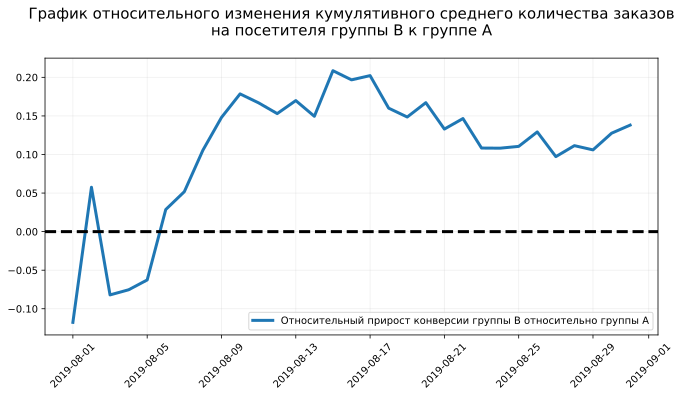

In [34]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']], 
                                      left_on='date',right_on='date', how='left', suffixes=['A', 'B'])
                              )

(plt.plot(mergedCumulativeConversions['date'],
          mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
          label="Относительный прирост конверсии группы B относительно группы A")
)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов' \
          +'\n' + 'на посетителя группы B к группе A'+"\n")
plt.xticks(rotation=45)
plt.legend();

В начале наблюдений группа В проигрывала группе А, но довольно резко ушла в отрыв. Потом произошел спад, но далее группа В опять резко улучшила свои показатели и далее всегда была луше, чем А. Далее постепено усрднялась.

##### Точечный график количества заказов по пользователям.

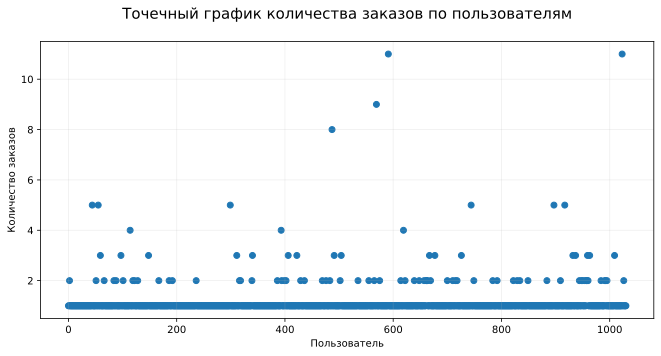

In [35]:
#определим количество заказов, которые совершил каждый пользователь
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

#визуализируем данные
ordersByUsers.columns = ['userId', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям'+"\n")
plt.ylabel('Количество заказов')
plt.xlabel('Пользователь');

In [36]:
#посмотрим основные статистики количества заказов
ordersByUsers['orders'].describe()

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders, dtype: float64

Много пользователей с 1 заказами. Реже встречаются с 2. Пользователи, совершившие больше 8 заказов за исследуемый период, вылудят уже подозрительно.

##### Определение 95-й и 99-й перцентили количества заказов на пользователя. 

In [37]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


Не более 1% совершали более 4 заказов.  
Не более 5% пользователей оформляли больше, чем 2 заказа.  
10% и больше пользователей оформили 1 заказ.

##### Точечный график стоимостей заказов

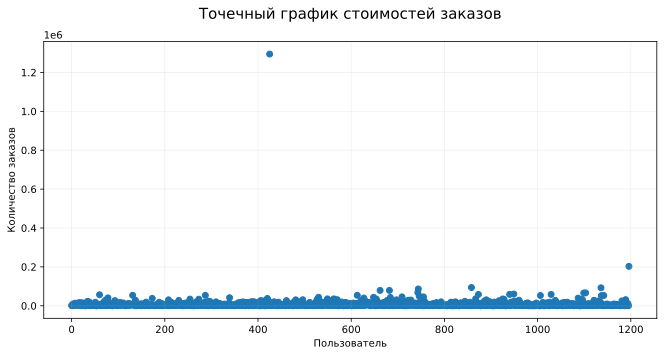

In [38]:
#определим стоимость заказов, которые представлены в данных

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов'+"\n")
plt.ylabel('Количество заказов')
plt.xlabel('Пользователь');

In [39]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Как ранее предполагали: есть выброс, дорогой заказ 1 294 500.

##### Определение 95-й и 99-й перцентили стоимости заказов

In [40]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Не более 5% заказов дороже 28 000   
и не более 1% дороже 58 233.  
10% и больше заказов меньше 18 168.

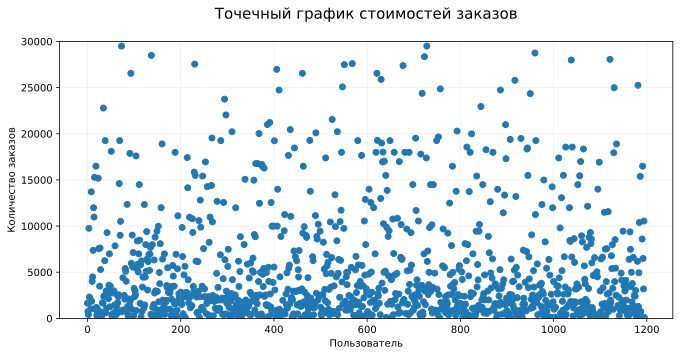

In [41]:
# исключим выбросы из точечного графика стоимости заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов'+"\n")
plt.ylabel('Количество заказов')
plt.ylabel('Пользователь')
plt.ylim([0, 30000])
plt.ylabel('Количество заказов')
plt.xlabel('Пользователь');

##### Определение статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Сформулируем нулевую и альтеративные гипотезы:  

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в среднем количестве заказов между группами нет. }\\
   H_1 :\text{различия в среднем между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [42]:
# соберем данные для дальнейшего анализа
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [43]:
#Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [44]:
#опредлим размер выборок
pd.DataFrame([len(sampleA),len(sampleB)], index = ['sample_A', 'sample_B'],columns=['count'])

,count
sample_A,18736
sample_B,18916


Так как выборки у нас независимые при проведении А/В теста, пользователи в различных группах, а сравниваем мы признаки измеренные количественно, то для проверки гипотез я буду использовать критерий Манна — Уитни.

In [45]:
# проверим выборки критерием Манна-Уитни
alpha=0.05

results = stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')
print('p-значение: ', round(results.pvalue,3))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('относительные различия:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.017
Отвергаем нулевую гипотезу
относительные различия: 0.138


**Вывод:**  
По «сырым» данным есть различий в среднем числе заказов групп A и B. 
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.  
Относительный прирост группы B составлняет 13.8% — второе число в выводе.

##### Определение статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем нулевую и альтеративные гипотезы:  

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в среднем чеке между группами нет. }\\
   H_1 :\text{различия в среднем чеке между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [46]:
alpha=0.05

results = (stats.mannwhitneyu
           (orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative='two-sided')
          )
print('p-значение: ', round(results.pvalue,3))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
#относительные различия в среднем чеке между группами
print('относительные различия:',\
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение:  0.729
Не получилось отвергнуть нулевую гипотезу
относительные различия: 0.259


P-value выше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что статистически значимых отличий в среднем чеке между группами, нет.  
Мы не смогли опровергнуть нулевую гипотезу, то средние чеки двух выборок равны. То различие которое мы наблюдаем - получено случайно.
Несмотря на различие в 26% выбранный критерий устойчив к тем аномалиям, которые определяют это различие.

##### Определение статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 28 000. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.  
Сделаем срезы пользователей с числом заказов **больше 4** — usersWithManyOrders  
и пользователей, совершивших заказы **дороже 28 000** — usersWithExpensiveOrders.  
Объединим их в таблице abnormalUsers. 

In [47]:
#определям пользователей с очень большим числом заказов, больше 95 перцнтиля
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsersA['orders'], 95)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsersB['orders'], 95)]['userId'],
    ],
    axis=0,
)
#определям пользователей с дорогаими заказами, больше 95 перцнтиля

usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorId']

# объединяем пользователей в одну таблицу
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
len(abnormalUsers)

74

Сформулируем нулевую и альтеративные гипотезы:  

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в среднем количестве заказов между группами нет. }\\
   H_1 :\text{различия в среднем между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [48]:
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [49]:
#Применим статистический критерий Манна-Уитни к полученным выборкам
alpha=0.05

results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')
print('p-значение: ', round(results.pvalue,3))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('относительные различия:','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-значение:  0.013
Отвергаем нулевую гипотезу
относительные различия: 0.173


Результаты по среднему количеству заказов практически не изменились. Статистическая значимость достигнута. Нулевую гипотезу отвергаем

#####  Определим статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Сформулируем нулевую и альтеративные гипотезы:  

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в среднем чеке между группами нет. }\\
   H_1 :\text{различия в среднем чеке между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [50]:
# подготовим выборки 
sampleA = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
sampleB = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']    

In [51]:
alpha=0.05

results = stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')
          
print('p-значение: ', round(results.pvalue,3))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
#относительные различия в среднем чеке между группами
print('относительные различия:',\
      '{0:.3f}'.format(sampleB.mean()/sampleA.mean()-1))

p-значение:  0.738
Не получилось отвергнуть нулевую гипотезу
относительные различия: -0.020


Первое число — p-value = 0.866 значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказов между группами нет, не отвергаем. Разница между сегментами сократилась, практически исчезла и составлняет 0.2% — второе число в выводе.

### Вывод

В резульльтат полученных данных, было выявлено наличие одинковых пользователях в двух группах. Точнее заказы для пользователй с одинаковыми индетифинаотрами попали в разные группы. Возможно это свойства условий опыта/системы.  
Необходимо разобраться и обяснить эту ситуацию или исключить повторение. Необходимо соблюсти условие, при котором каждый пользователь попавший в одну из групп остатся в этой групп до конца теста.

*Приоритезация гипотез выявила тройку приоритетных:*
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


*Имеющиеся факты на основании проведенного анализа результатов А/B теста:*
* Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;

* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

* График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению;

* График различия среднего чека говорит о том, что результаты группы B лучше группы А, в большей части эксперимента.


Исходя из обнаруженных фактов, тест следует остановить и признать его состоявшимся. 
После проведенного анализа и очистки данных сегмент В на самом деле лучше А, так как заказов у В выше, чем А. Однако средний чек не имеет значимых различий между сегментами, особенно после очистки.

Но, по-хорошему, лучше проверить результаты А/А теста и понять проводился ли он. :)